### Imports

In [1]:
import numpy as np
import sklearn as skl
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import panel as pn

In [2]:
pn.extension()

### Utils

#### Functions for generating datasets
Below are custom functions for generating 2d Gaussians, ring-like structures and 'half-moon' structures.
All three types of structures are common for dummy datasets. You can also generate them (and some other distributions)
using functions from sklearn.data. The functions below give you a little bit more control + you can use them as templates for creating
your own functions for more complex dummy datasets.

In [3]:
def generate_gaussian_cluster(n_points=100, center=(0, 0), sigma_x=1.0, sigma_y=1.0, rotation=0.0):
    cov = np.array([[sigma_x**2, 0],
                    [0, sigma_y**2]])
    
    # rotate covariance matrix
    theta = np.radians(rotation)
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    
    cov_rotated = R @ cov @ R.T
    points = np.random.multivariate_normal(center, cov_rotated, n_points)
    return points


In [4]:
def generate_elliptical_ring(n_points=100, center=(0, 0), radius_x=5.0, radius_y=3.0, noise=0.1):
    angles = np.random.uniform(0, 2 * np.pi, n_points)
    x = center[0] + radius_x * np.cos(angles) + np.random.normal(0, noise, n_points)
    y = center[1] + radius_y * np.sin(angles) + np.random.normal(0, noise, n_points)
    return np.stack([x, y], axis=1)


In [5]:
def generate_half_moon(n_points=100, center=(0, 0), radius=1.0, width=0.3, noise=0.05, rotation=0.0, arc=180):
    # angles for the arc
    angles = np.linspace(0, np.radians(arc), n_points)
    inner_radius = radius - width

    # radius values between inner and outer arc
    r = np.random.uniform(inner_radius, radius, size=n_points)
    x = r * np.cos(angles)
    y = r * np.sin(angles)

    # apply rotation
    theta = np.radians(rotation)
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta),  np.cos(theta)]])
    coords = np.dot(np.stack([x, y], axis=0).T, rot_matrix)

    # add center and noise
    coords += np.array(center)
    coords += np.random.normal(0, noise, coords.shape)

    return coords


#### Visualization

In [6]:
def plot_clusters(*datasets, labels=None, title="Generated Data", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    for i, data in enumerate(datasets):
        label = labels[i] if labels else f"Cluster {i+1}"
        ax.scatter(data[:, 0], data[:, 1], label=label, alpha=0.6)
    ax.set_title(title)
    ax.legend()
    ax.axis("equal")
    return ax

In [7]:
def plot_kmeans(X, labels, centers=None, title="k-means result",ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', alpha=0.6)
    if centers is not None:
        ax.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=100)
    ax.set_title(title)
    ax.axis('equal')
    return ax

#### Testing visualization

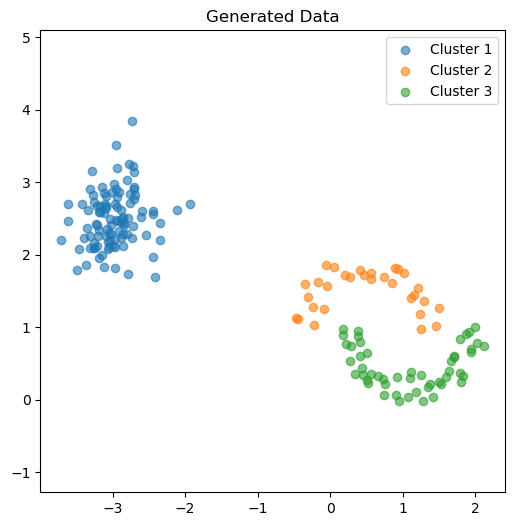

In [8]:
dataset1 = generate_gaussian_cluster(n_points=100,center=(-3,2.4),sigma_x=0.3,sigma_y=0.4,rotation=0.3)
dataset2 = generate_half_moon(n_points=30,center=(0.5,1))
dataset3 = generate_half_moon(n_points=50,center=(1.1,1),rotation=180)
plot_clusters(dataset1,dataset2,dataset3);

## Clustering algorithms

### K-means

K-means is an UML clustering algorithm. It tries to assign the data to a predefined number of clusters, minimizing the variance (Euclidian distance ^2) within each cluster. It works by assigning each point to the nearest cluster center and iteratively updating those centers to better fit the data.
1) User defines the number of clusters `k`.
2) Initialize `k` cluster centroids randomly.
3) Calculate distance from each point to each centroid.
4) Assign the point to the nearest centroid (by default using Euclidean distance).
6) Recalculate centroids as the mean of all assigned points.
7) Repeat steps 3–4 until cluster assignments stop changing or a max number of iterations is reached.

Docs: https://scikit-learn.org/stable/modules/clustering.html#k-means

In [9]:
g1 = generate_gaussian_cluster(150, center=(0, 1), sigma_x=0.5, sigma_y=0.5)
g2 = generate_gaussian_cluster(150, center=(0.5, 4), sigma_x=2, sigma_y=0.5)
g3 = generate_gaussian_cluster(150, center=(0, 8), sigma_x=0.5, sigma_y=0.5)

data1 = np.vstack([g1, g2, g3])

Silhouette score: 0.6151041367014386


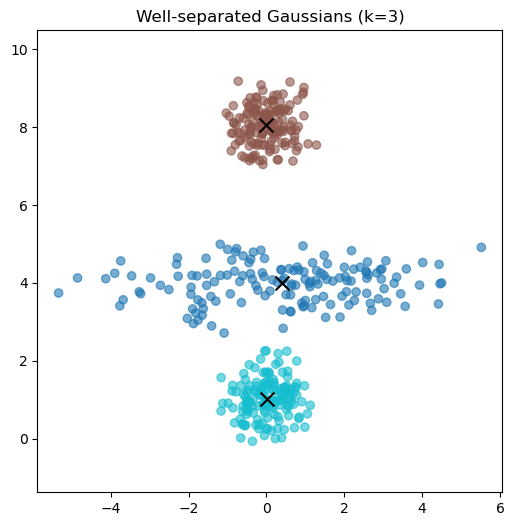

In [10]:
kmeans1 = KMeans(n_clusters=3, random_state=1,max_iter=300,tol=1e-5).fit(data1)
plot_kmeans(data1, kmeans1.labels_, centers=kmeans1.cluster_centers_,
            title="Well-separated Gaussians (k=3)")

print("Silhouette score:", silhouette_score(data1, kmeans1.labels_))

<Axes: title={'center': 'Ground truth'}>

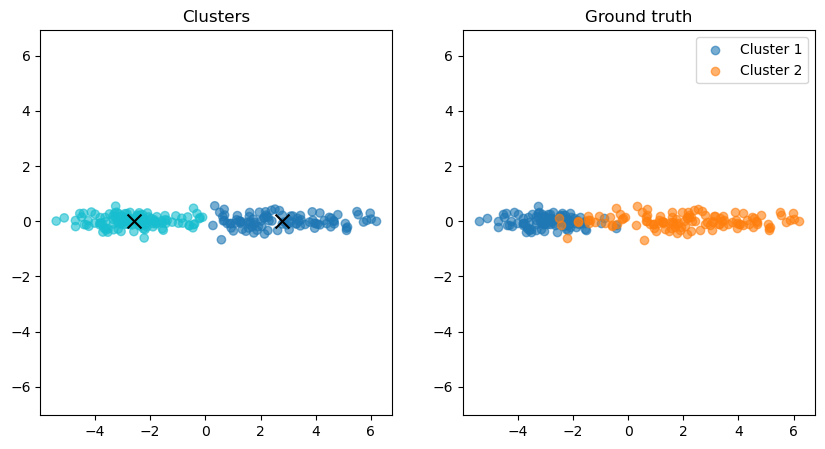

In [11]:
g4 = generate_gaussian_cluster(100, center=(-3, 0), sigma_x=1.0, sigma_y=0.2, rotation=0)
g5 = generate_gaussian_cluster(120, center=(2, 0), sigma_x=2.0, sigma_y=0.2, rotation=0)

data2 = np.vstack([g4, g5])

kmeans2 = KMeans(n_clusters=2, random_state=0).fit(data2)

fig, axs = plt.subplots(figsize=(10,5),ncols=2,nrows=1)
plot_kmeans(data2, kmeans2.labels_, centers=kmeans2.cluster_centers_,
            title="Clusters",ax=axs[0])
plot_clusters(g4,g5,
            title="Ground truth",ax=axs[1])

<Axes: title={'center': 'Half-Moons (k=2)'}>

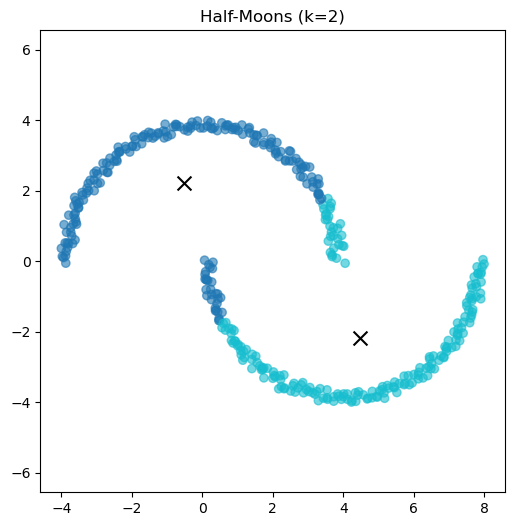

In [12]:
m1 = generate_half_moon(n_points=200, center=(0, 0), radius=4)
m2 = generate_half_moon(n_points=200, center=(4, 0), radius=4, rotation=180)

data3 = np.vstack([m1, m2])

kmeans3 = KMeans(n_clusters=2, random_state=1).fit(data3)
plot_kmeans(data3, kmeans3.labels_, centers=kmeans3.cluster_centers_,
            title="Half-Moons (k=2)")

K-means weaknesses:

- Assumes clusters are roughly spherical and equally sized.
- Sensitive to outliers and initial centroid placement.
- You have to set the number of clusters in advance (how would you know that for real n-Dim data?)
- Performs poorly with non-globular clusters or varying densities.

### Evaluation metrics

#### Elbow method
When Kmeans calculates which data points belongs to which cluster, it optimizes intra-cluster squared distances, aka variance, aka kmeans.inertia_. For well-separated clusters, we can use this parameter to determine optimal number of clusters. For this we need to fit the data with different `k` value, calculate inertia, and make a plot for it. For the optimal (or 'optimal') number of clusters there will be a point at which the plot goes from rapidly decreasing regime to a slowly-decreasing regime. This 'elbow' point shows the `k` value after which larger number of clusters does not do any good. You can find it by eyeballing, or by taking a derivative.

In [13]:
def plot_elbow(X, k_range=range(1, 11), ax=None, title="Elbow Method"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        inertias.append(kmeans.inertia_)

    ax.plot(list(k_range), inertias, marker='o')
    ax.set_xlabel("Number of clusters (k)")
    ax.set_ylabel("Inertia (within-cluster sum of squares)")
    ax.set_title(title)
    ax.grid(True)

    return inertias, ax

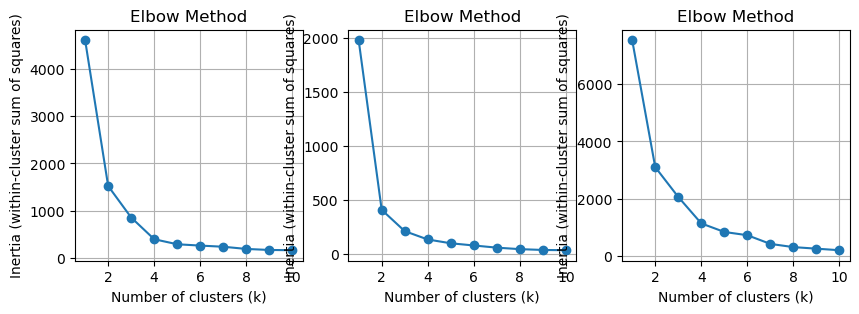

In [14]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
plot_elbow(data1,ax=axs[0])
plot_elbow(data2,ax=axs[1])
plot_elbow(data3,ax=axs[2]);

#### Exercise: Elbow method testing
1) Create a dataset of well-separated non-overlapping gaussians with larger number of clusters (~10)
2) Check the performance of the elbow method for this dataset
3) Now move some of the clusters closer to each other or increase their sigmas. How does it affect elbow method performance?

#### Interactivity time: inspecting how kmeans behaves when we pass it incorrect number of clusters

In [15]:
def kmeans_plot(data, k,max_iter=300):
    kmeans = KMeans(n_clusters=k, random_state=0,max_iter=max_iter).fit(data)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    fig, ax = plt.subplots(figsize=(3, 3))
    plot_kmeans(data, labels=labels, centers=centers, ax=ax,
                             title=f"K-means Clustering (k={k}),n_iter={max_iter}")
    plt.close(fig)
    return fig

In [16]:
k_slider = pn.widgets.IntSlider(name='Number of clusters (k)', start=1, end=10, value=3)

plot_pane = pn.pane.Matplotlib()

# Update callback
def update_plot(event=None):
    fig = kmeans_plot(data1, k_slider.value)
    plot_pane.object = fig

# Watch slider changes
k_slider.param.watch(update_plot, 'value')

# Layout
layout = pn.Column(
    k_slider,
    plot_pane
)
update_plot()

Column
    [0] IntSlider(end=10, name='Number of clusters (k)', start=1, value=3)
    [1] Matplotlib(Figure)
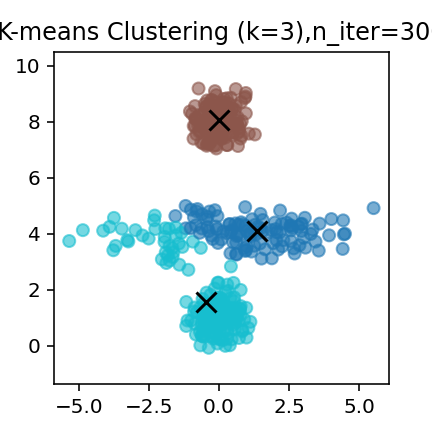

In [17]:
layout.servable()

#### Silhouette method
We can estimate the quality of clustering by evaluating how well a data point fits within its assigned cluster and compare this estimate to other clusters. It gives a score between -1 and 1 for each point, with 1 being good and -1 being completely misclassified. 
1) For each point `i` we calculate its average distance to the members of its assigned cluster A
2) Then we calculate its average distance to the nearest neighbor cluster B
3) $S=\frac{B-A}{max(A,B)}$
4) The average silhouette score over all points summarizes the overall clustering performance.

Docs: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

In [18]:
def plot_silhouette_scores(X, k_range=range(2, 11), ax=None, title="Silhouette Score vs. k"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        scores.append(score)

    ax.plot(list(k_range), scores, marker='o')
    ax.set_xlabel("Number of clusters (k)")
    ax.set_ylabel("Silhouette score")
    ax.set_title(title)
    ax.grid(True)

    return scores, ax


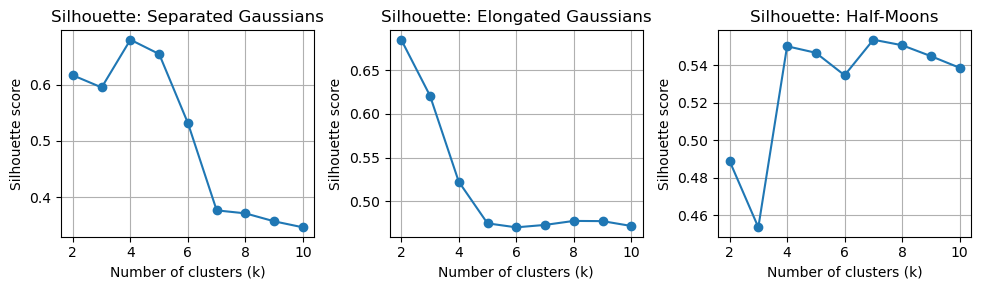

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

plot_silhouette_scores(data1, ax=axes[0], title="Silhouette: Separated Gaussians")
plot_silhouette_scores(data2, ax=axes[1], title="Silhouette: Elongated Gaussians")
plot_silhouette_scores(data3, ax=axes[2], title="Silhouette: Half-Moons")

plt.tight_layout()
plt.show()


#### Silhouette analysis - inspect silhouetter scores for each point

In [20]:
def plot_silhouette_analysis(X, n_clusters, ax=None, title_prefix=""):
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    if ax is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    else:
        ax1, ax2 = ax
        fig = ax1.figure

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_sil = sample_silhouette_values[cluster_labels == i]
        ith_cluster_sil.sort()
        size_cluster_i = ith_cluster_sil.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil,
                          facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10

    ax1.set_title(f"{title_prefix}Silhouette plot (k={n_clusters})")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])

    # Cluster scatter plot
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=60, lw=0, alpha=0.7, c=colors, edgecolor='k')
    #plot_kmeans(X,centers=clusterer.cluster_centers_,ax=ax2,labels=cluster_labels)

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='x', c='black', s=200)

    ax2.set_title(f"{title_prefix}Cluster visualization")
    ax2.set_xlabel("Feature 1")
    ax2.set_ylabel("Feature 2")
    fig.suptitle(f"Silhouette analysis for k={n_clusters} | Avg = {silhouette_avg:.3f}", fontsize=14)

    return silhouette_avg, fig, (ax1, ax2)

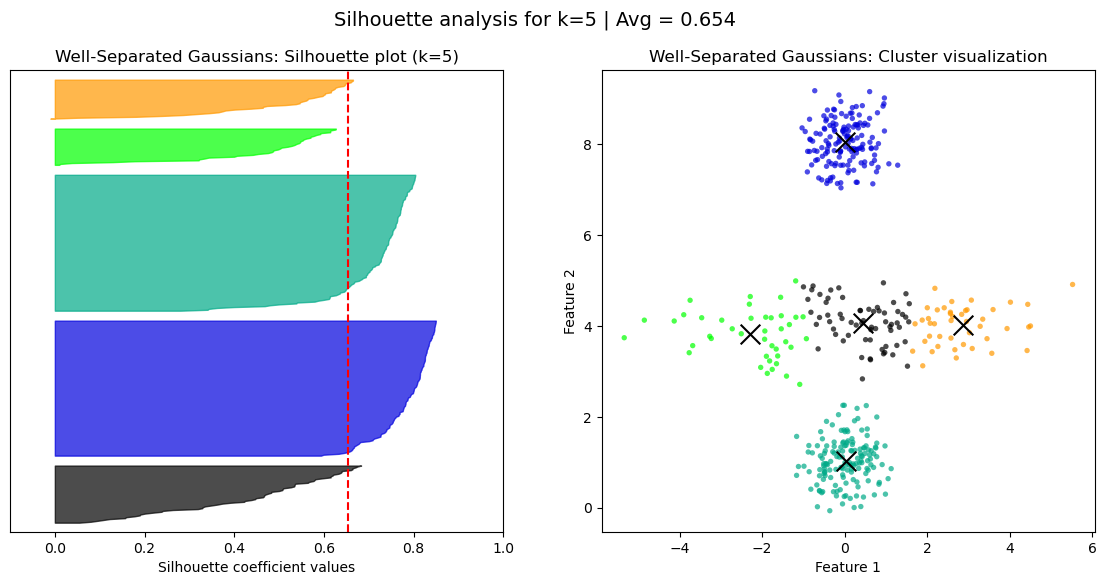

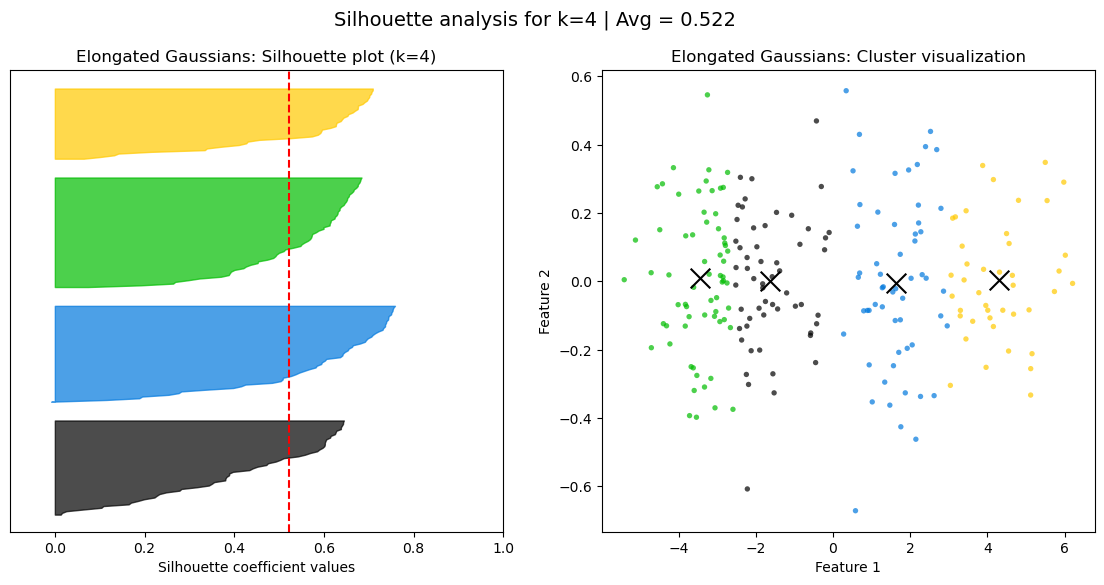

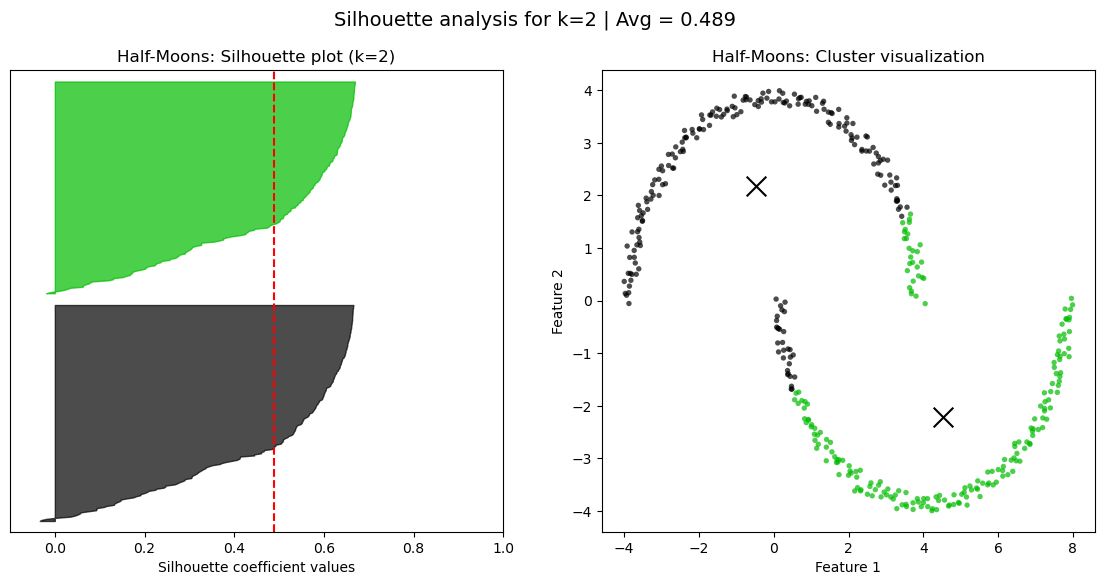

In [21]:
_ = plot_silhouette_analysis(data1, n_clusters=5, title_prefix="Well-Separated Gaussians: ")
_ = plot_silhouette_analysis(data2, n_clusters=4, title_prefix="Elongated Gaussians: ")
_ = plot_silhouette_analysis(data3, n_clusters=2, title_prefix="Half-Moons: ")
plt.show()


### HDBScan

HDBSCAN (aka Hierarchical Density-Based Spatial Clustering of Applications with Noise) analyzes the density of data points to find regions of overdensity separated by regions of underdensity. It iteratively looks through the found structures, merging the nearest ones using `cluster_selection_epsilon` threshold parameter, and checks for cluster's stability -> 'hierarchy'. The datapoints that are away from all clusters are considered to be noise.
1) Calculate 'mutual reachability distance' metric that incorporates local density near the data point of interest
2) Build a minimum spanning tree - a tree to connect all the points in a way that minimizes the MRT metric.
5) Construct a hierarchy of clusters: go through the tree merging closest points into clusters
6) Condense the tree: vary density thresholds and prune the clusters that are not persistent
7) Extract flat clusters from the hierarchy based on their stability.
8) Label remaining points as noise (if they don’t fit into any stable cluster).

Docs: https://scikit-learn.org/stable/modules/clustering.html#hdbscan

In [22]:
def run_hdbscan(X, min_cluster_size=20, min_samples=None, epsilon=0.0):
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size,min_samples=min_samples,cluster_selection_epsilon=epsilon)
    labels = clusterer.fit_predict(X)
    return labels, clusterer

In [23]:
def plot_hdbscan_clusters(X, labels, ax=None, title="HDBSCAN Clustering"):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    unique_labels = np.unique(labels)
    colors = cm.tab20b(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        if label == -1:
            color = 'gray'
            marker = 'x'
        else:
            marker = 'o'

        mask = (labels == label)
        ax.scatter(X[mask, 0], X[mask, 1],
                   c=[color], marker=marker, alpha=0.7, label=f"Cluster {label}" if label != -1 else "Noise")

    ax.set_title(title, fontsize=10)
    ax.axis("equal")
    ax.legend(loc="best", frameon=False)
    return ax


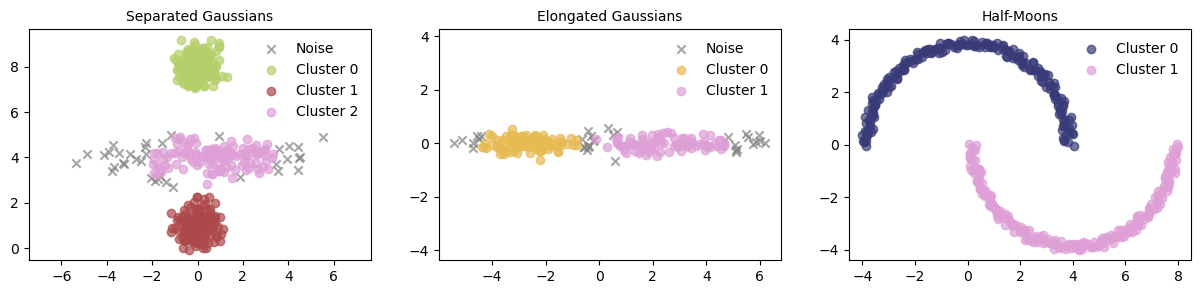

In [24]:
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

labels1, model1 = run_hdbscan(data1)
plot_hdbscan_clusters(data1, labels1, title="Separated Gaussians",ax=axs[0])

labels2, model2 = run_hdbscan(data2)
plot_hdbscan_clusters(data2, labels2, title="Elongated Gaussians",ax=axs[1])

labels3, model3 = run_hdbscan(data3)
plot_hdbscan_clusters(data3, labels3, title="Half-Moons",ax=axs[2]);

#### Interactivity time: How HDBSCAN parameters affect its performance

In [26]:
min_cluster_slider = pn.widgets.IntSlider(name='min_cluster_size', start=2, end=100, value=20)
min_samples_slider = pn.widgets.IntSlider(name='min_samples', start=1, end=50, value=5)

img_pane = pn.pane.Matplotlib()

In [27]:
# Update callback
def update_plot(event=None):
    min_cluster = min_cluster_slider.value
    min_samples = min_samples_slider.value
    labels, _ = run_hdbscan(data, min_cluster,min_samples)
    fig, ax = plt.subplots(figsize=(3,3))
    plot_hdbscan_clusters(data, labels,
            title=f"HDBSCAN (min_cluster_size={min_cluster}",ax=ax)
    plt.close(fig)
    plot_pane.object = fig

In [28]:
data=data2

min_cluster_slider.param.watch(update_plot, 'value')
min_samples_slider.param.watch(update_plot, 'value')
layout=pn.Row(pn.Column(min_cluster_slider,min_samples_slider),plot_pane)
update_plot()

Row
    [0] Column
        [0] IntSlider(end=100, name='min_cluster_size', start=2, value=20)
        [1] IntSlider(end=50, name='min_samples', start=1, value=5)
    [1] Matplotlib(Figure)
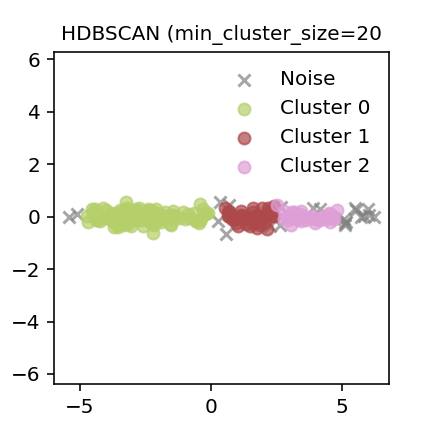

In [29]:
layout.servable()

#### Silhouette analysis

In [30]:
def plot_hdbscan_analysis(X, labels, title_prefix="HDBSCAN", min_cluster_size=None):
    """
    Silhouette plot + cluster scatter plot.

    Parameters:
    - X: np.array of shape (n_samples, 2)
    - labels: cluster labels from HDBSCAN
    - title_prefix: optional string prefix for titles
    - min_cluster_size: optional, just for including in the title

    Returns:
    - silhouette_avg (or None)
    """
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    mask = labels != -1
    if np.sum(mask) == 0 or len(np.unique(labels[mask])) < 2:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        ax1.text(0.5, 0.5, "Not enough clusters for silhouette plot", 
                 ha='center', va='center', fontsize=12)
        ax1.set_axis_off()
        ax2.set_axis_off()
        return None

    X_clean = X[mask]
    labels_clean = labels[mask]

    silhouette_vals = silhouette_samples(X_clean, labels_clean)
    silhouette_avg = silhouette_score(X_clean, labels_clean)

    # Create color mapping based on cluster labels
    unique_labels = sorted(set(labels))
    color_map = {label: cm.tab20b(i / max(1, len(unique_labels))) for i, label in enumerate(unique_labels)}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"{title_prefix} clustering (min_cluster_size={min_cluster_size})\nAvg silhouette: {silhouette_avg:.3f}",
                 fontsize=14)

    # Silhouette Plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_clean) + (len(np.unique(labels_clean)) + 1) * 10])

    y_lower = 10
    for label in np.unique(labels_clean):
        vals = silhouette_vals[labels_clean == label]
        vals.sort()
        y_upper = y_lower + len(vals)
        color = color_map[label]
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * len(vals), str(label))
        y_lower = y_upper + 10

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster Label")
    ax1.set_yticks([])

    # Scatter Plot
    for label in unique_labels:
        color = color_map[label] if label != -1 else "gray"
        marker = 'x' if label == -1 else 'o'
        mask = labels == label
        ax2.scatter(X[mask, 0], X[mask, 1], 
                    c=[color], marker=marker, alpha=0.7,
                    label=f"Cluster {label}" if label != -1 else "Noise")

    ax2.set_title("Cluster Visualization")
    ax2.set_xlabel("Feature 1")
    ax2.set_ylabel("Feature 2")
    ax2.legend(loc="best", frameon=False)
    ax2.axis("equal")

    plt.tight_layout()
    return silhouette_avg


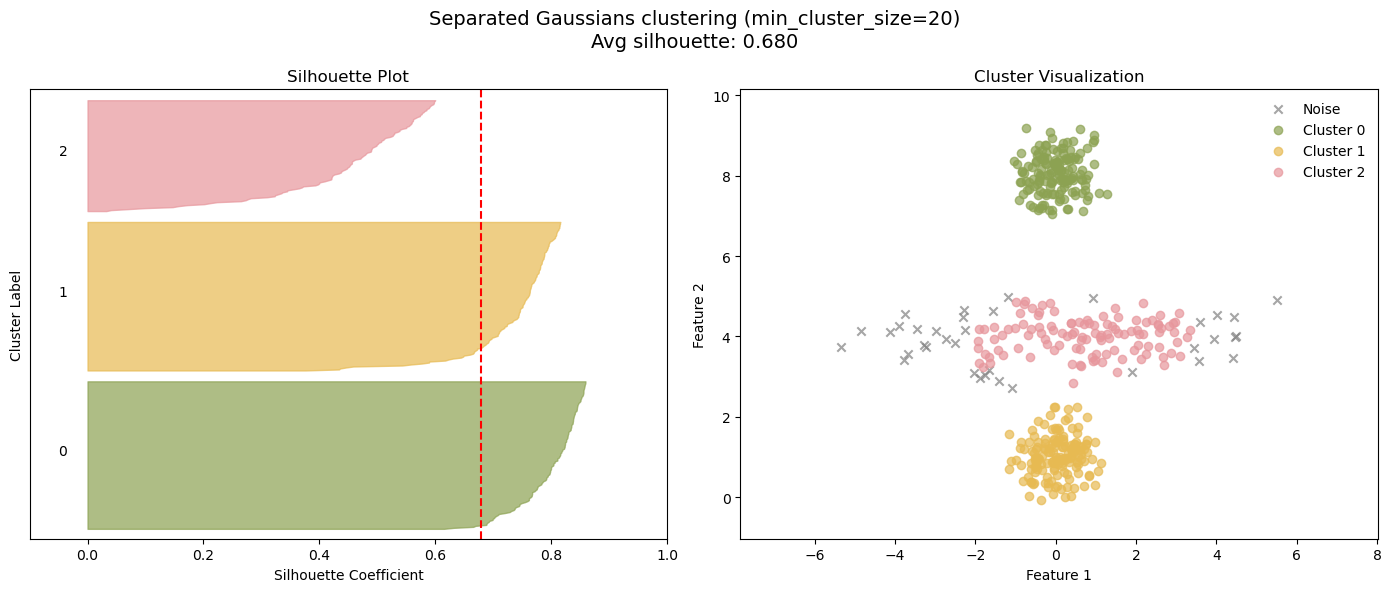

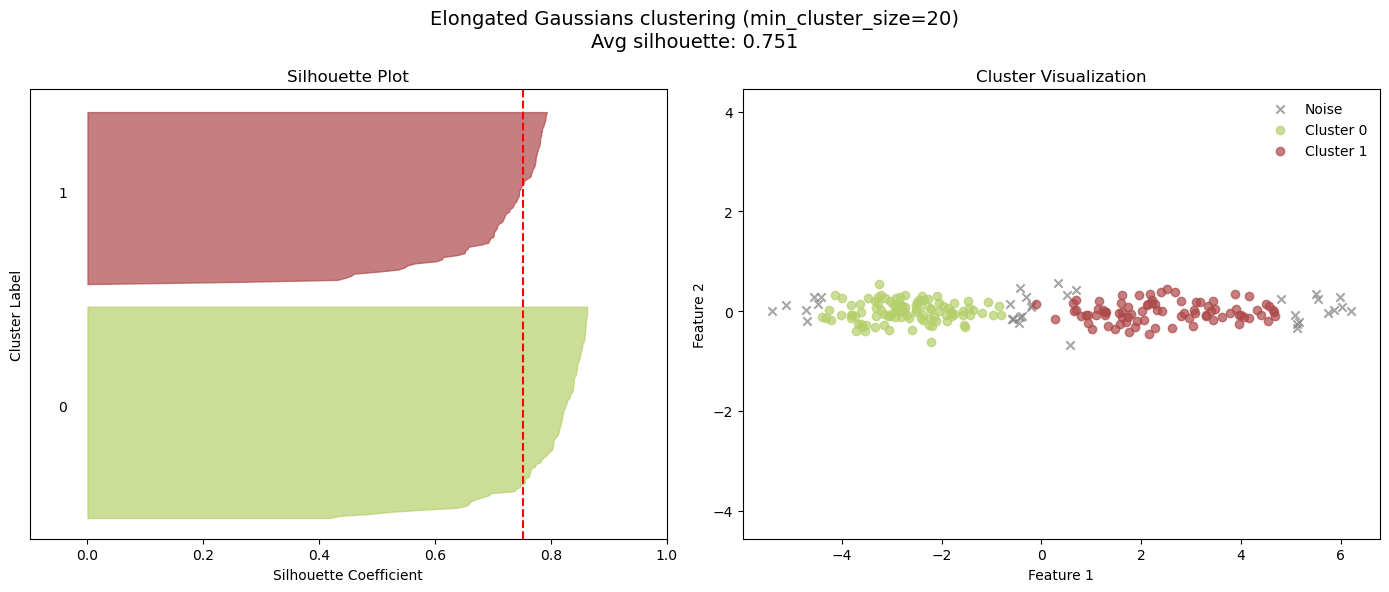

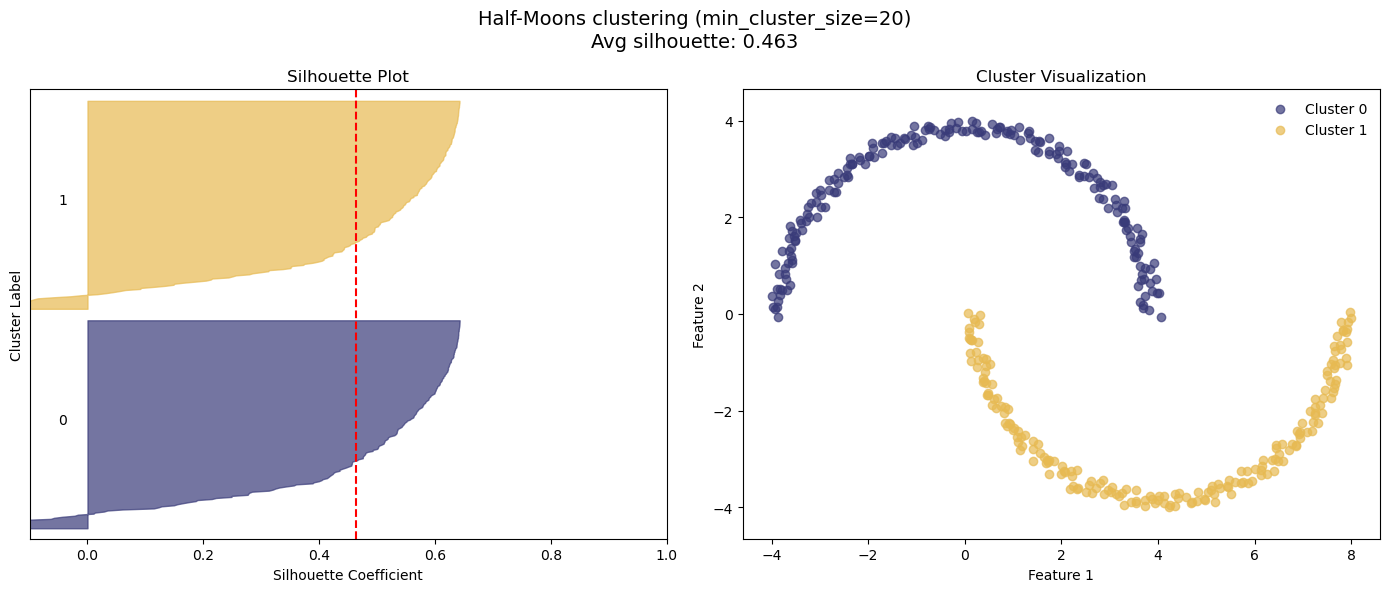

In [31]:
plot_hdbscan_analysis(data1, labels1, title_prefix="Separated Gaussians", min_cluster_size=20)
plot_hdbscan_analysis(data2, labels2, title_prefix="Elongated Gaussians", min_cluster_size=20)
plot_hdbscan_analysis(data3, labels3, title_prefix="Half-Moons", min_cluster_size=20);

#### HDBSCAN advanced
There is a better implementation of HDBSCAN than in Sklearn: https://hdbscan.readthedocs.io/en/latest/index.html. Using this library, you can visualize cool dendrograms of you clustering + use additional features like soft clustering + it's a little bit faster. 

### Exercise: Break the algorithm!
1) Think on what kinds of datasets may cause problems for HDBScan
2) Generate those datasets, trying different parameters for clusters separation, sizes, numbers of data points, overlapping
3) Apply HDBScan on these datasets. Try changing algorithm parameters, e.g. min_samples and epsilon
4) Which aspects of the datasets cause the most problems? In which cases Silhouette analysis allows you to predict whether the algorithm handled clusterization well?